In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import cvxpy
import matplotlib.pyplot as plt

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from collections import Counter

from statsmodels.stats.outliers_influence import variance_inflation_factor

Напишем функции для подсчета коэффициента корреляции Пирсона и генерации матриц Sim и Rel.

In [2]:
def get_sim(X):
    return np.abs(np.corrcoef(X.T))

def get_rel(X, y):
    return np.abs(np.corrcoef(X.T, y)[:-1, -1])

Напишем функции для генерации данных.

In [8]:
def generate_first_data(size, eps, loc=0, scale=1):
    # генерируем y и x1 из стандартного нормального распределения
    
    # y - целевая переменная
    y = sps.norm(loc=loc, scale=scale).rvs(size=size)
    
    # x1 - первый признак
    x1 = sps.norm(loc=loc, scale=scale).rvs(size=size)

    # x2 - второй признак
    x2 = x1 + eps * y
    X = np.array([x1, x2]).T
    return X, y

In [9]:
def generate_noise_features(sample_size, n_features, loc=0, scale=1):
    X_noise = sps.norm(loc=loc, scale=scale).rvs(size=(sample_size, n_features))
    return X_noise

Напишем функцию для решения задачи квадратичного программирования.

In [10]:
def solve_qpfs_original(b, Q, alpha=0.5):
    beta = alpha / (1. - alpha + 1e-10) 
    # 1e-10 to ensure it is finite.
    # No practical change is expected
    a = cvxpy.Variable(Q.shape[1])

    problem = cvxpy.Problem(cvxpy.Maximize(b.T @ a - cvxpy.quad_form(a, 0.5 * Q)), [a >= 0, cvxpy.sum(a) == beta])
    problem.solve(solver='ECOS')

    return a.value

In [11]:
def get_all_first_data(sample_size, noise_features, eps):
    X_main, y = generate_first_data(sample_size, eps)
    
    if noise_features > 0:
        X_noise = generate_noise_features(sample_size, noise_features)
        # соберем итоговую матрицу признаков, добавив шумовые признаки
        X = np.hstack((X_main, X_noise))
    else:
        # соберем итоговую матрицу признаков
        X = X_main
        
    return X, y

Напишем функцию для подсчета индекса мультиколлинеарности.

In [18]:
def get_VIF(X):
    # возвращаем максимальный из VIF по признакам в датасете
    return np.array([variance_inflation_factor(X, i) for i in range(X.shape[1])]).max()

Решим задачу оптимизации методом QPFS для отбора признаков.

\begin{cases}
a^* = \arg \min_{a \in [0, 1]^n}  \frac{1}{2}a^T Q a - b^T a \\
\|a\|_1 \le 1, a \ge 0
\end{cases}

In [12]:
def get_qpfs_experiment(X, y):
    
    # получим матрицы Rel и Q
    b = get_rel(X, y)
    Q = get_sim(X)
    
    # QBFS-метод
    a = solve_qpfs_original(b, Q)
    
    return a

Напишем функции для эксперимента с Ridge-регрессией и Lasso-регрессией.

In [13]:
def get_ridge(X_train, y_train, X_test, y_test, alpha):
    scaler = StandardScaler()

    # обучим этот класс на обучающей выборке
    scaler.fit(X_train)

    # применим стандартизацию к обучающей и тестовой выборкам
    X_train_stand = scaler.transform(X_train)
    X_test_stand = scaler.transform(X_test)
    
    model = Ridge(alpha=alpha)

    model.fit(X_train_stand, y_train)
    
    ridge_mse = mean_squared_error(model.predict(X_test_stand), y_test)
    
    # количество шумовых признаков в случае ridge-регрессии считаем как
    # количество признаков,коэффициенты при которых не очень близки к нулю
    curr_noise = (model.coef_ >= 0.000001).sum()
    
    ridge_VIF = get_VIF(X_train)
    
    return ridge_VIF, curr_noise, ridge_mse
    

In [14]:
def get_lasso(X_train, y_train, X_test, y_test, alpha):
    
    # стандартизируем признаки
    scaler = StandardScaler()

    # обучим этот класс на обучающей выборке
    scaler.fit(X_train)

    # применим стандартизацию к обучающей и тестовой выборкам
    X_train_stand = scaler.transform(X_train)
    X_test_stand = scaler.transform(X_test)
    
    model = Lasso(alpha=alpha)

    model.fit(X_train_stand, y_train)
    
    lasso_mse = mean_squared_error(model.predict(X_test_stand), y_test)
    
    lasso_VIF = get_VIF(X_train[:, model.coef_ != 0])
    
    curr_noise = (model.coef_[2:] != 0).sum()
    
    return lasso_VIF, curr_noise, lasso_mse

Также сделаем функции для qpfs-метода с разными порогами.

In [16]:
def get_qpfs_2_features(X_train, y_train, X_test, y_test):
    
    # qpfs (отбираем оба главных признака)
    best_a = get_qpfs_experiment(X_train, y_train)
    
    # устанавливаем порог tau как наименьшее значение среди best_a[0] и best_a[1], 
    # чтобы отобрать два признака и смотрим сколько шумовых признаков еще отобрали
    threshold = best_a[:2].min()
    
    # оставляем только отобранные признаки
    qpfs_X_train = X_train[:, best_a >= threshold]
    
    # cмотрим, сколько шумовых признаков отобрано
    curr_noise = qpfs_X_train.shape[1] - 2  # вычитаем 2, т.к. два основных признака точно отобрали
    
    # делаем обычную линейную регрессию
    model = LinearRegression()
    model.fit(qpfs_X_train, y_train)
    
    
    qpfs_mse = mean_squared_error(model.predict(X_test[:, best_a >= threshold]), y_test)
    
    qpfs_VIF = get_VIF(qpfs_X_train)
    
    return qpfs_VIF, curr_noise, qpfs_mse

In [17]:
def get_qpfs_some_features(X_train, y_train, X_test, y_test, threshold=0.00001):
    
    # qpfs (отбираем один главный признак)
    best_a = get_qpfs_experiment(X_train, y_train)
    
    # оставляем только отобранные признаки (cравниваем с переданным порогом threshold)
    qpfs_X_train = X_train[:, best_a >= threshold]
    
    # cмотрим, сколько шумовых признаков отобрано
    curr_noise = qpfs_X_train.shape[1] - (best_a[:2] >= threshold).sum()
    # берем только один основной признак
    
    # делаем обычную линейную регрессию
    model = LinearRegression()
    model.fit(qpfs_X_train, y_train)
    
    qpfs_mse = mean_squared_error(model.predict(X_test[:, best_a >= threshold]), y_test)
    
    qpfs_VIF = get_VIF(qpfs_X_train)
    
    return qpfs_VIF, curr_noise, qpfs_mse

Напишем общую функцию для запуска эксперимента.

In [31]:
def get_first_experiment(train_sample_size, noise_features, eps, test_size, alpha=0.01, threshold=0.00001):
    # сгенерируем данные для обучения
    X_train, y_train = get_all_first_data(train_sample_size, noise_features, eps)
    
    # сгенерируем данные для теста
    X_test, y_test = get_all_first_data(test_size, noise_features, eps)
    
    qpfs_2_features = np.array(get_qpfs_2_features(X_train, y_train, 
                                                   X_test, y_test))
    
    qpfs_some_features = np.array(get_qpfs_some_features(X_train, y_train, 
                                                         X_test, y_test, threshold))
    
    ridge_res = np.array(get_ridge(X_train, y_train, X_test, y_test, alpha))
    
    lasso_res = np.array(get_lasso(X_train, y_train, X_test, y_test, alpha))
    
    res = np.vstack((qpfs_2_features, qpfs_some_features, ridge_res, lasso_res))
    
    
    return res

In [32]:
def show_results(res_matrix):
    return pd.DataFrame(res_matrix,
                        index=['QPFS (с отбором двух главных признаков)', 'QPFS c фикс. порогом', 
                               'Ridge', 'Lasso'], 
                        columns=['VIF', 'Количество шумовых признаков', 
                                 'MSE на тестовой выборке'])

### Данные для эксперимента

In [22]:
train_sample_size = 1000
noise_features = 10
eps = 0.001

# коэф-т регуляризации для Ridge и Lasso
alpha = 0.01

test_size = 100

In [34]:
# проведем один эксперимент
show_results(get_first_experiment(train_sample_size, noise_features, eps, test_size))

,VIF,Количество шумовых признаков,MSE на тестовой выборке
QPFS (с отбором двух главных признаков),1.064966e+06,8.0,1.570173e-25
QPFS c фикс. порогом,1.003991e+00,8.0,1.241498e+00
Ridge,1.065099e+06,7.0,1.136862e+00
Lasso,1.003991e+00,8.0,1.235759e+00


А теперь сделаем несколько экспериментов и усредним результаты.

In [37]:
num_attempts = 100

In [39]:
# усредним результаты
mean_results = np.array([get_first_experiment(train_sample_size, 
                                              noise_features, eps, test_size) 
                         for i in range(num_attempts)]).mean(axis=0)

In [19]:
# выведем усредненные значения
show_results(mean_results)

,VIF,Количество шумовых признаков,MSE на тестовой выборке
QPFS (с отбором двух главных признаков),1.023882e+06,8.96,1.170779e-23
QPFS c фикс. порогом,1.014672e+00,8.74,1.045660e+00
Ridge,1.023911e+06,5.90,9.505797e-01
Lasso,1.012684e+00,7.55,1.040215e+00


In [40]:
np.log10(100)

2.0

Подбор параметра $\tau$.

In [42]:
def set_threshold(train_sample_size, noise_features, eps, test_size, alpha=0.01,
                  threshold_values = np.logspace(-10, 0, 1000)):
    
    # сгенерируем данные для обучения
    X_train, y_train = get_all_first_data(train_sample_size, noise_features, eps)
    
    curr_a = get_qpfs_experiment(X_train, y_train)
    
    # будем сохранять количество отобранных шумовых признаков 
    # и отобранных главных признаков
    res_noise_cnt = []
    res_main_cnt = []
    
    for threshold in threshold_values:
        curr_noise_cnt = (curr_a[2:] >= threshold).sum()
        curr_main_cnt = (curr_a[:2] >= threshold).sum()
        
        res_noise_cnt.append(curr_noise_cnt)
        res_main_cnt.append(curr_main_cnt)
    
    
    res_noise_cnt = np.array(res_noise_cnt)
    res_main_cnt = np.array(res_main_cnt)
    
    plt.figure(figsize=(12, 5))
    plt.plot(np.log10(threshold_values), res_noise_cnt, label='шумовые признаки')
    plt.plot(np.log10(threshold_values), res_main_cnt, label='основные признаки')
    
    plt.title(f'Количество отобранных признаков (N = {noise_features})')
    plt.ylabel('Количество отобранных признаков', fontsize=12)
    plt.xlabel(r'ln($\tau$)', fontsize=12)
    plt.legend(loc='best', fontsize=14)
    
   
    pass

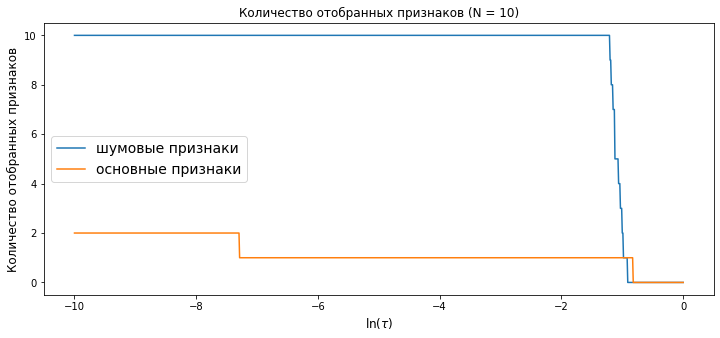

In [45]:
set_threshold(train_sample_size, 10, eps, test_size)

Сравним на данном датасете QPFS и Lasso.

In [47]:
def get_hist(train_sample_size, noise_features, eps, test_size, alpha=0.01,
                  threshold_values = np.logspace(-11, -1, 100)):
    
    res = []
    for i in range(100):
        X_train, y_train = get_all_first_data(train_sample_size, noise_features, eps)
        # сгенерируем данные для теста
        X_test, y_test = get_all_first_data(test_size, noise_features, eps)


        best_a = get_qpfs_experiment(X_train, y_train)

        # устанавливаем порог tau как наименьшее значение среди best_a[0] и best_a[1], 
        # чтобы отобрать два признака и смотрим сколько шумовых признаков еще отобрали
        threshold = best_a[:2].min()

        # оставляем только отобранные признаки
        qpfs_X_train = X_train[:, best_a >= threshold]

        # cмотрим, сколько шумовых признаков отобрано
        curr_noise = qpfs_X_train.shape[1] - 2  # вычитаем 2, т.к. два основных признака точно отобрали

        res.append(curr_noise)
        
    return res
        
    pass

In [48]:
res = get_hist(train_sample_size, noise_features, eps, test_size)

In [121]:
list(Counter(res).keys())

[10, 9, 8, 7]

No handles with labels found to put in legend.


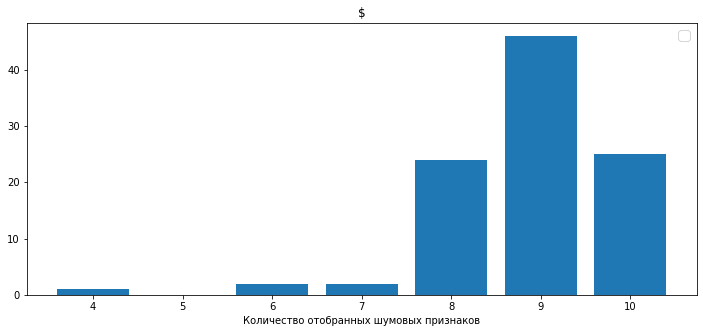

In [49]:
plt.figure(figsize=(12, 5))

plt.bar(list(Counter(res).keys()), Counter(res).values())
    
plt.title('$')
plt.xlabel('Количество отобранных шумовых признаков')
#plt.ylabel('колич№')
plt.legend(loc='best', fontsize=14)
plt.show()

**Второй эксперимент**

$x_1 = y + \varepsilon_1$, $\varepsilon_1 \sim N(0, s_1^2)$

$x_2 = y + \varepsilon_2$, $\varepsilon_2 \sim N(0, s_2^2)$

In [168]:
def generate_second_data(size, s1=0.5, s2=1, loc=0, scale=1):
    # y - целевая переменная из норм. распределения
    y = sps.norm(loc=loc, scale=scale).rvs(size=size)
    
    # x1 - первый признак (добавляем норм. шум с дисперсией s2^2)
    x1 = y + sps.norm(loc=0, scale=s1).rvs(size=size)

    # x2 - второй признак (добавляем норм. шум с дисперсией s2^2)
    x2 = y + sps.norm(loc=0, scale=s2).rvs(size=size)
    
    X = np.array([x1, x2]).T
    return X, y

In [169]:
def get_all_second_data(sample_size, noise_features, s1=0.5, s2=1):
    X_main, y = generate_second_data(sample_size, s1=s1, s2=s2)
    
    if noise_features > 0:
        X_noise = generate_noise_features(sample_size, noise_features)
        # соберем итоговую матрицу признаков, добавив шумовые признаки
        X = np.hstack((X_main, X_noise))
    else:
        # соберем итоговую матрицу признаков
        X = X_main
        
    return X, y

In [177]:
def get_second_experiment(train_sample_size, noise_features, test_size, alpha=0.01, 
                          threshold=0.00001, s1=0.5, s2=1):
    # сгенерируем данные для обучения
    X_train, y_train = get_all_second_data(train_sample_size, noise_features, 
                                           s1=s1, s2=s2)
    
    # сгенерируем данные для теста
    X_test, y_test = get_all_second_data(test_size, noise_features,
                                         s1=s1, s2=s2)
    
    qpfs_2_features = np.array(get_qpfs_2_features(X_train, y_train, 
                                                   X_test, y_test))
    
    qpfs_some_features = np.array(get_qpfs_some_features(X_train, y_train, 
                                                         X_test, y_test, threshold))
    
    ridge_res = np.array(get_ridge(X_train, y_train, X_test, y_test, alpha))
    
    lasso_res = np.array(get_lasso(X_train, y_train, X_test, y_test, alpha))
    
    res = np.vstack((qpfs_2_features, qpfs_some_features, ridge_res, lasso_res))
    
    
    return res

In [178]:
train_sample_size = 1000
noise_features = 10


# коэф-т регуляризации для Ridge и Lasso
alpha = 0.01

test_size = 100

In [179]:
s2=1

s1_values = np.linspace(0, 2, 21)

first_prob = []
second_prob = []

for s1 in s1_values:
    X_train, y_train = get_all_second_data(train_sample_size, noise_features, 
                                           s1=s1, s2=s2)

    res = []

    for i in range(10):
        X_train, y_train = get_all_second_data(train_sample_size, noise_features, 
                                               s1=s1, s2=s2)
        res.append(get_qpfs_experiment(X_train, y_train))
    res = np.array(res).mean(axis=0)
    
    first_prob.append(res[0])
    second_prob.append(res[1])

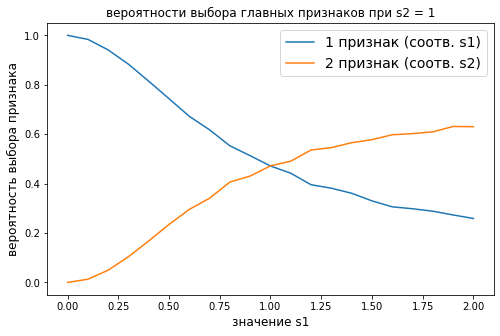

In [180]:
plt.figure(figsize=(8, 5))
plt.plot(s1_values, first_prob, label='1 признак (соотв. s1)')
plt.plot(s1_values, second_prob, label='2 признак (соотв. s2)')
 
plt.title('вероятности выбора главных признаков при s2 = 1')
plt.ylabel('вероятность выбора признака', fontsize=12)
plt.xlabel(r'значение s1', fontsize=12)
plt.legend(loc='best', fontsize=14)
plt.show()

Видим, что чем с большей вероятностью отбирается признак с меньшей дисперсией шума.

Проведем эксперимент по сравнению методов как в первом случае.

In [182]:
# проведем один эксперимент
show_results(get_second_experiment(train_sample_size, noise_features, test_size, 
                                   s1=0.5, s2=1))

,VIF,Количество шумовых признаков,MSE на тестовой выборке
QPFS (с отбором двух главных признаков),1.679330,0.0,0.145547
QPFS c фикс. порогом,1.682598,4.0,0.148898
Ridge,1.695668,7.0,0.151388
Lasso,1.691302,4.0,0.146296


А теперь сделаем несколько экспериментов и усредним результаты.

In [185]:
num_attempts = 100

In [187]:
# усредним результаты
mean_results = np.array([get_second_experiment(train_sample_size, 
                                               noise_features, test_size,
                                               s1=0.5, s2=1) 
                         for i in range(num_attempts)]).mean(axis=0)

In [189]:
# выведем усредненные значения
show_results(mean_results)

,VIF,Количество шумовых признаков,MSE на тестовой выборке
QPFS (с отбором двух главных признаков),1.688270,0.00,0.172557
QPFS c фикс. порогом,1.695303,3.64,0.173370
Ridge,1.708281,7.20,0.173992
Lasso,1.697362,4.35,0.172914


In [206]:
def set_threshold_second(train_sample_size, noise_features, test_size, alpha=0.01,
                         threshold_values = np.logspace(-11, 0, 100), s1=0.5, s2=1):
    
    # сгенерируем данные для обучения
    X_train, y_train = get_all_second_data(train_sample_size, noise_features, 
                                           s1=s1, s2=s2)
    
    curr_a = get_qpfs_experiment(X_train, y_train)
    
    # будем сохранять количество отобранных шумовых признаков 
    # и отобранных главных признаков
    res_noise_cnt = []
    res_main_cnt = []
    
    for threshold in threshold_values:
        curr_noise_cnt = (curr_a[2:] >= threshold).sum()
        curr_main_cnt = (curr_a[:2] >= threshold).sum()
        
        res_noise_cnt.append(curr_noise_cnt)
        res_main_cnt.append(curr_main_cnt)
    
    
    res_noise_cnt = np.array(res_noise_cnt)
    res_main_cnt = np.array(res_main_cnt)
    
    plt.figure(figsize=(8, 5))
    plt.plot(np.log10(threshold_values), res_noise_cnt, label='шумовые признаки')
    plt.plot(np.log10(threshold_values), res_main_cnt, label='основные признаки')
    
    plt.title('График количества отобранных признаков при s1 = 0.5, s2 = 1')
    plt.ylabel('Количество отобранных признаков', fontsize=12)
    plt.xlabel(r'$\log_{10}(\tau)$', fontsize=12)
    plt.legend(loc='best', fontsize=14)
    
    #plt.
    pass

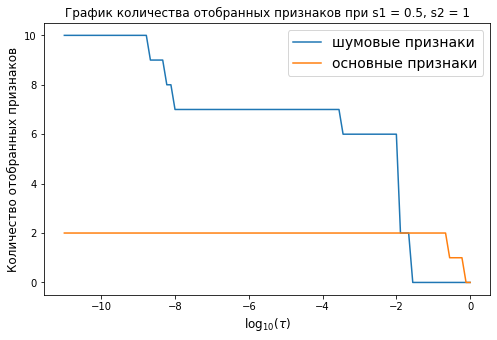

In [207]:
set_threshold_second(train_sample_size, noise_features, test_size, s1=s1, s2=s2)

Видим, что при s1 = 0.5, s2 = 1 два основных признака отбираются даже при маленьких значениях порога $\tau$.

А теперь тот же эксперимент, но при s1 = s2.

In [208]:
# усредним результаты
mean_results = np.array([get_second_experiment(train_sample_size, 
                                               noise_features, test_size,
                                               s1=1, s2=1) 
                         for i in range(num_attempts)]).mean(axis=0)

In [209]:
# выведем усредненные значения
show_results(mean_results)

,VIF,Количество шумовых признаков,MSE на тестовой выборке
QPFS (с отбором двух главных признаков),1.337562,0.00,0.333534
QPFS c фикс. порогом,1.345085,4.91,0.335713
Ridge,1.354506,6.96,0.336928
Lasso,1.348386,5.93,0.334598


Видим, что на таком датасете мы получили гораздо более близкие значения VIF у разных методов.

Эксперимент с число обусловленности.

In [65]:
sample_size = 100
nu = 0.3
n_features = 10

$x_j = y + \nu * \varepsilon_j$

In [99]:
nu_values = np.logspace(-6, -2, 100)

res_values = []

for curr_nu in nu_values:
    curr_res = []
    for i in range(100):
        y = sps.norm.rvs(size=sample_size)
        Eps = sps.norm.rvs(size=(sample_size, n_features))
        X = (curr_nu * Eps.T + y).T
        curr_res.append(np.linalg.eigvals(X.T @ X).max() / np.linalg.eigvals(X.T @ X).min())
      
    # сохраняем полученное усредненное значение
    res_values.append(np.mean(curr_res))

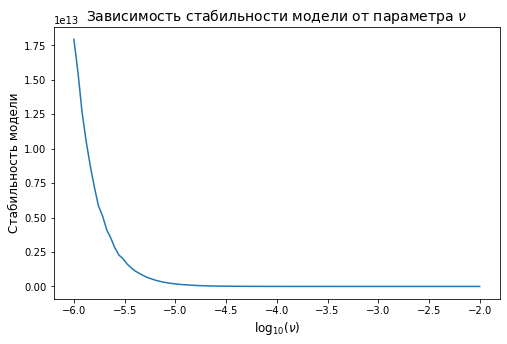

In [108]:
plt.figure(figsize=(8, 5))
plt.plot(np.log10(nu_values), res_values)
plt.title(r'Зависимость стабильности модели от параметра $\nu$', fontsize=14)
plt.ylabel('Стабильность модели', fontsize=12)
plt.xlabel(r'$\log_{10}(\nu)$', fontsize=12)
plt.show()

In [63]:
np.linalg.eigvals(X.T @ X).max() / np.linalg.eigvals(X.T @ X).min()

7.908484187055527